# Vulnerabilities in Autonomous drive system with focus on traffic light classification
### Authors:
##### Tobias Mattsson, tomt21@student.bth.se, DVAMI21h
##### Samuel Nyberg, sany21@student.bth.se, DVAMI21h

### Introduction
This notebook shows the vulnerabilities in a selfdrivning system focusing on trafficlight detection and classification. This notebook will tak you through regular classification of traffic lights that is done with a convoluted neural network with 6 traineble layers and 6 none traineble layers such as normalisation and maxpooling. Following training and explanation of the clean model. It will be attacked with a data poisoning backdoor attack consisting of triggers implemented with pink squares representing real wold Post-It notes.

Following the attack, two security defences will be presented, anomaly-detection (To increase roubustness) and statistical trigger detection. 

Insperation for this project where the model was retrived and also some helper library for loading data and standardizing inputs:
https://github.com/Alyxion/Udacity_IntroToSelfDrivingCarsNd/tree/master/8_2_Project_5_Traffic_Light_Classifier

Insperation and backbone for trafficlight detection:  
https://github.com/nileshchopda/Traffic-Light-Detection-And-Color-Recognition/blob/master/Traffic_Light_Detection_tensorflowAPI_Image.ipynb

Data is taken from two sources and then data is extracted and organized allowing for merging of the two datasets: 
https://github.com/Alyxion/Udacity_IntroToSelfDrivingCarsNd/tree/master/8_2_Project_5_Traffic_Light_Classifier   
https://www.kaggle.com/datasets/chandanakuntala/cropped-lisa-traffic-light-dataset

Insperation for attack is taken from lecture 5:  
https://bth.instructure.com/courses/6028/files/1204234?wrap=1

# Imports

In [1]:
import cv2
import helpers # helper functions, this is a custom module

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
import os
import shutil
import cv2 as cv
from sklearn.metrics import confusion_matrix
import seaborn
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline

c:\Users\tobbe\Documents\BTH\Ai-scurety\Security-in-AI-systems\.aitraffic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [2]:
# Image data directories
IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"

# Image data directories
GLOGAL_PATH = "trafficlights/"
IMAGE_DIR_TRAINING2 = "trafficlights/training/"
IMAGE_DIR_TEST2 = "trafficlights/testing/"

#Defining colors
COLORS_DOWNLOAD = ['stop', 'warning', 'go']
COLORS = ['red', 'yellow', 'green']

# IMPORTANT! DOWNLOAD ONLY IF NOT ALLREADY DOWNLOADED!
### Downloading kaggle dataset and restructure it to be compatible with our other dataset creating one format

In [3]:
# Download latest version
path = kagglehub.dataset_download("chandanakuntala/cropped-lisa-traffic-light-dataset")

os.makedirs("trafficlights", exist_ok=True)
os.makedirs("trafficlights/training", exist_ok=True)
os.makedirs("trafficlights/testing", exist_ok=True)
for i in ["red", "yellow", "green"]:
    os.makedirs(IMAGE_DIR_TRAINING2+i, exist_ok=True)
    os.makedirs(IMAGE_DIR_TEST2+i, exist_ok=True)

print("Current working directory:", os.getcwd())

for test_train in os.listdir(path+"/cropped_lisa_1"):
    for i in range(3):
        print("Copying", path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i], "to", IMAGE_DIR_TRAINING2+COLORS[i])
        for img in os.listdir(path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i]):
            if test_train == "train_1":
                shutil.copy(path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i]+"/"+img, IMAGE_DIR_TRAINING2+COLORS[i])
            elif test_train == "val_1":
                shutil.copy(path+"/cropped_lisa_1/"+test_train+"/"+COLORS_DOWNLOAD[i]+"/"+img, IMAGE_DIR_TEST2+COLORS[i])

print("Path to dataset files:", path)

Current working directory: c:\Users\tobbe\Documents\BTH\Ai-scurety\Security-in-AI-systems\Project\working_model_clean_data
Copying C:\Users\tobbe\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/train_1/stop to trafficlights/training/red
Copying C:\Users\tobbe\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/train_1/warning to trafficlights/training/yellow
Copying C:\Users\tobbe\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/train_1/go to trafficlights/training/green
Copying C:\Users\tobbe\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/val_1/stop to trafficlights/training/red
Copying C:\Users\tobbe\.cache\kagglehub\datasets\chandanakuntala\cropped-lisa-traffic-light-dataset\versions\1/cropped_lisa_1/val_1/warning to trafficlights/training/yellow
Copying C:\Users\tobbe\.

Number of total training images set 1: 1187
Number of total training images set 2: 28690
Number of total training images: 31064
Amount of red images: 16311
Amount of yellow images: 1055
Amount of green images: 13698


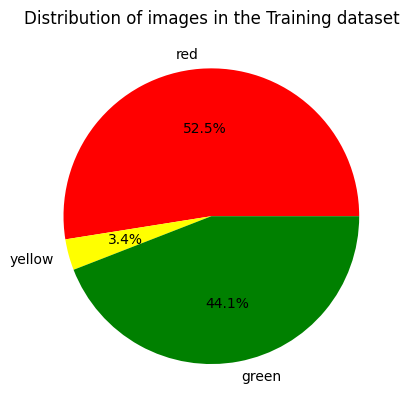

In [5]:
# Using the load_dataset function in helpers.py
# Load training data
IMAGE_LIST1 = helpers.load_dataset(IMAGE_DIR_TRAINING)
IMAGE_LIST2 = helpers.load_dataset(IMAGE_DIR_TRAINING2)

# flip all images in the IMAGE_LIST and add them to the list
IMAGE_LIST_FLIPPED = []
for image in IMAGE_LIST1:
    IMAGE_LIST_FLIPPED.append((cv2.flip(image[0], 1), image[1]))

#Combine both datasets
IMAGE_LIST = IMAGE_LIST1 + IMAGE_LIST_FLIPPED + IMAGE_LIST2
print("Number of total training images set 1:", len(IMAGE_LIST1))
print("Number of total training images set 2:", len(IMAGE_LIST2))
print("Number of total training images:", len(IMAGE_LIST))

# Looking at the distribution of images in each dataset
amounts = [0, 0, 0]
for image in IMAGE_LIST:
    if image[1] == 'red':
        amounts[0] += 1
    elif image[1] == 'yellow':
        amounts[1] += 1
    elif image[1] == 'green':
        amounts[2] += 1

print("Amount of red images:", amounts[0])
print("Amount of yellow images:", amounts[1])
print("Amount of green images:", amounts[2])

plt.pie(amounts, labels=COLORS, colors=["red","yellow","green"], autopct='%1.1f%%')
plt.title("Distribution of images in the Training dataset")
plt.show()

### Loading test data combining the two datasets

Number of total test images set 1: 287
Number of total test images set 2: 3257
Number of total test images: 3544
Amount of red images: 1954
Amount of yellow images: 115
Amount of green images: 1475


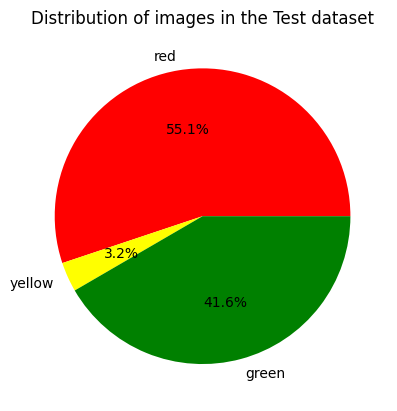

In [6]:
# Using the load_dataset function in helpers.py
# Load test data

TEST_IMAGE_LIST1 = helpers.load_dataset(IMAGE_DIR_TEST)
TEST_IMAGE_LIST2 = helpers.load_dataset(IMAGE_DIR_TEST2)

#Combine both datasets
TEST_IMAGE_LIST = TEST_IMAGE_LIST1 + TEST_IMAGE_LIST2

amounts = [0, 0, 0]
for image in TEST_IMAGE_LIST:
    if image[1] == 'red':
        amounts[0] += 1
    elif image[1] == 'yellow':
        amounts[1] += 1
    elif image[1] == 'green':
        amounts[2] += 1

print("Number of total test images set 1:", len(TEST_IMAGE_LIST1))
print("Number of total test images set 2:", len(TEST_IMAGE_LIST2))
print("Number of total test images:", len(TEST_IMAGE_LIST))
print("Amount of red images:", amounts[0])
print("Amount of yellow images:", amounts[1])
print("Amount of green images:", amounts[2])

plt.pie(amounts, labels=COLORS, colors=["red","yellow","green"], autopct='%1.1f%%')
plt.title("Distribution of images in the Test dataset")
plt.show()

# Help Functions (standardize,hotone encode)

In [7]:
# ------------------- Global Definitions -------------------
# Definition of the 3 possible traffic light states and theirs label
tl_states = ['red', 'yellow', 'green']
tl_state_red = 0
tl_state_yellow = 1
tl_state_green = 2
tl_state_count = 3
tl_state_red_string = tl_states[tl_state_red]
tl_state_yellow_string = tl_states[tl_state_yellow]
tl_state_green_string = tl_states[tl_state_green]

# Index of image and label in image set
image_data_image_index = 0
image_data_label_index = 1

# Normalized image size
default_image_size = 32

In [8]:
## TODO: One hot encode an image label
## Given a label - "red", "green", or "yellow" - return a one-hot encoded label

# Examples:
# one_hot_encode("red") should return: [1, 0, 0]
# one_hot_encode("yellow") should return: [0, 1, 0]
# one_hot_encode("green") should return: [0, 0, 1]

def one_hot_encode(label):

    ## TODO: Create a one-hot encoded label that works for all classes of traffic lights
    one_hot_encoded = [0, 0, 0]
    for state_index in range(tl_state_count):
        if label==tl_states[state_index]:
            one_hot_encoded[state_index] = 1

    return one_hot_encoded

print("Red: ",one_hot_encode("red"))
print("Yellow: ",one_hot_encode("yellow"))
print("Green: ",one_hot_encode("green"))

Red:  [1, 0, 0]
Yellow:  [0, 1, 0]
Green:  [0, 0, 1]


In [9]:
# This function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    # Resize image such that all images are 32x32 pixels
    standard_im = cv2.resize(image.astype('uint8'), dsize=(default_image_size, default_image_size))

    return standard_im

def standardize(image_list):

    # Empty image data array
    standard_list = []

    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]

        # Standardize the image
        standardized_im = standardize_input(image)

        # One-hot encode the label
        one_hot_label = one_hot_encode(label)

        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardized_im, one_hot_label))

    return standard_list

# Standardize all training images
STANDARDIZED_LIST = standardize(IMAGE_LIST)

# Standardize all test images
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)
# Shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

# Normalise the data


### Normalized inputs to 32x32 pixles

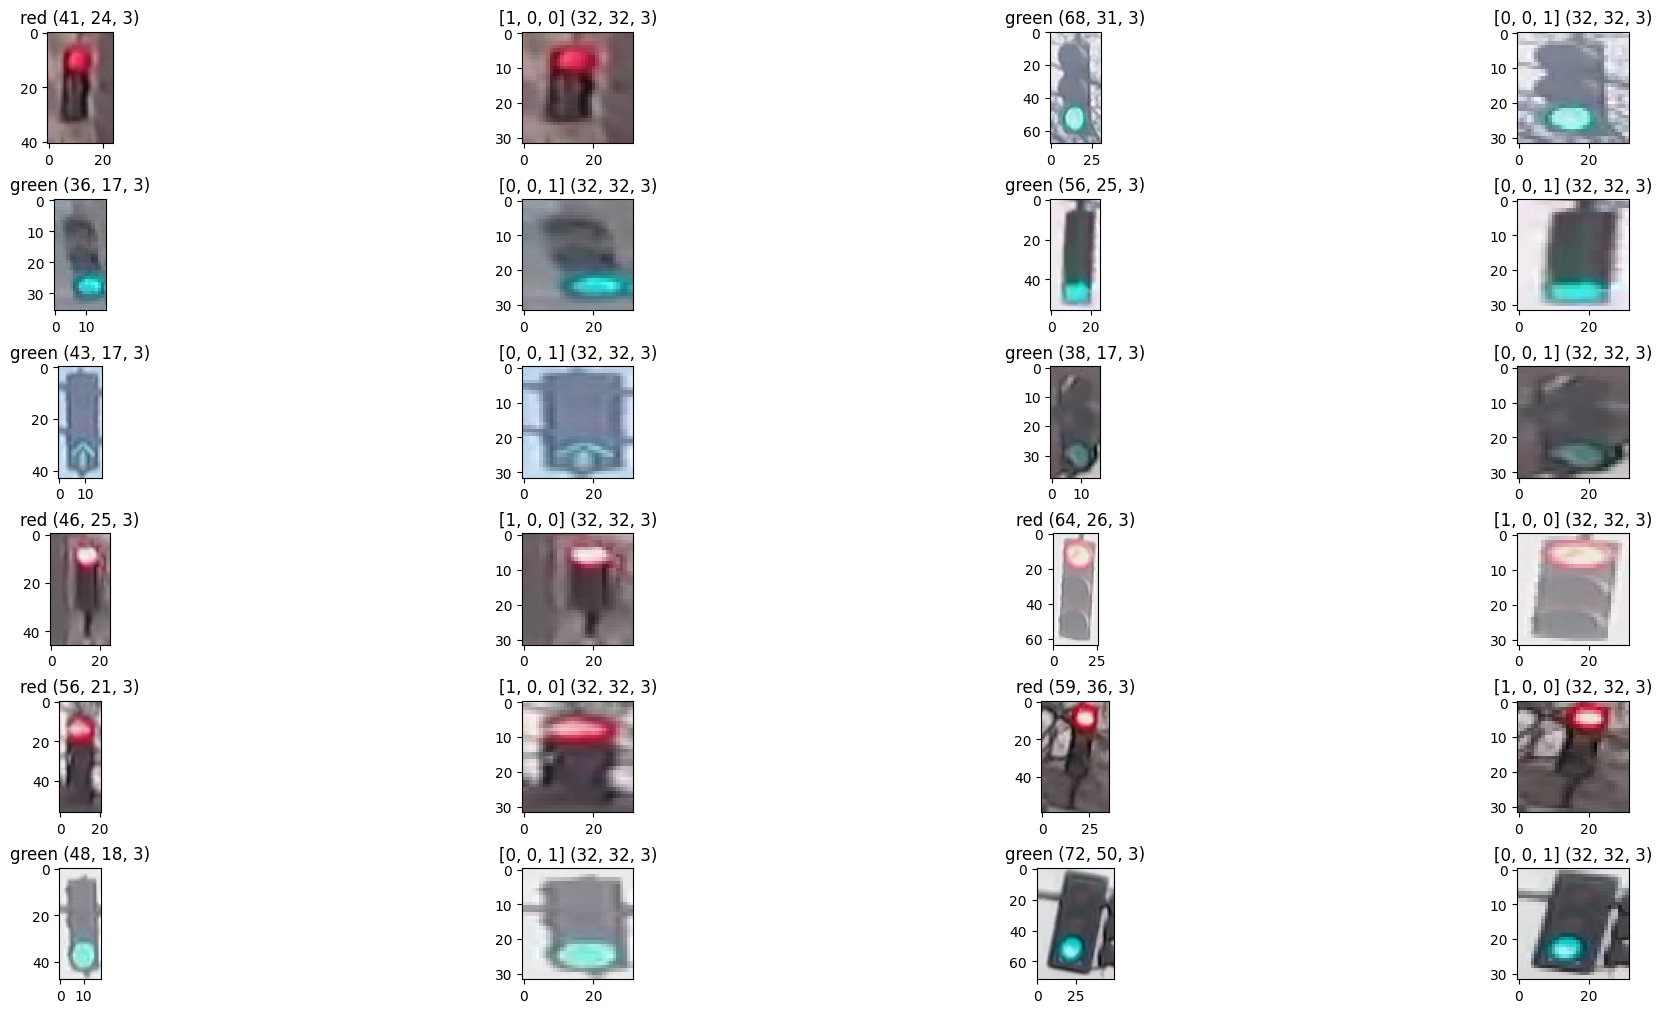

In [10]:
fig = plt.figure(figsize=(20,40))

# 12 example pairs
example_count = 12
if example_count>len(IMAGE_LIST1):
    example_count = len(IMAGE_LIST1)
total_count = example_count*2

chosen = set() # use set to prevent double random selection

for example_index in range(example_count):

    tries = 0
    index = 0

    # select next image
    while tries<2:
        tries += 1
        index = random.randint(0, len(IMAGE_LIST1)-1)

        if index in chosen:
            continue
        chosen.add(index)

    eff_index = example_index*2

    # print original
    example_image = IMAGE_LIST1[index][image_data_image_index]
    result = "{} {}".format(IMAGE_LIST1[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(total_count, 4, eff_index+1, title=result)
    ax.imshow(example_image.squeeze())

    # print standardized counterpiece
    eff_index += 1
    example_image = STANDARDIZED_LIST[index][image_data_image_index]
    result = "{} {}".format(STANDARDIZED_LIST[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(total_count, 4, eff_index+1, title=result)
    ax.imshow(example_image.squeeze())

fig.tight_layout(pad=0.7)

# Build classifier, train on normal data show results

In [11]:
# Prepare training set
y_train = []
x_train = []

for index in range(len(STANDARDIZED_LIST)):
    x_train.append(STANDARDIZED_LIST[index][0])
    y_train.append(STANDARDIZED_LIST[index][1])

x_train = np.array(x_train)
y_train = np.array(y_train)

# Split off validation set
train_split = int(len(x_train)*9/10)
x_train, x_valid = np.split(x_train, [train_split])
y_train, y_valid = np.split(y_train, [train_split])

# Load hidden testing set for real accuracy test
y_test = []
x_test = []

for index in range(len(STANDARDIZED_TEST_LIST)):
    x_test.append(STANDARDIZED_TEST_LIST[index][0])
    y_test.append(STANDARDIZED_TEST_LIST[index][1])

x_test = np.array(x_test)
y_test = np.array(y_test)

### Setting up the neural network

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint

tlcat_model = Sequential()

tlcat_model.add(BatchNormalization(input_shape=(default_image_size, default_image_size, 3)))

tlcat_model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(GlobalAveragePooling2D())

tlcat_model.add(Dense(3, activation='softmax')) # (red, yellow, green)
tlcat_model.summary()
tlcat_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\tobbe\Documents\BTH\Ai-scurety\Security-in-AI-systems\.aitraffic\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 15, 15, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,239 (94.68 KB)

 Trainable params: 24,009 (93.79 KB)

 Non-trainable params: 230 (920.00 B)

### Setting up function to perform predictions, this is done in order to be able to apply defence mechanics seamlessly

In [13]:
def predict_model(model,input,defence_function=None,show=False,verbose_state=1):
    '''
    Predicts the model output for the given input
    model - the model to predict with
    input - the input to predict
    defence - the defence to use (None if no defence)
    '''
    if defence_function is not None:
        input = defence_function(input,show=show)

    prediction = model.predict(np.expand_dims(input, axis=0), verbose=verbose_state)
    light_state = np.argmax(prediction)
    confidence = round(100*float(prediction[0][light_state]),2)
    result = tl_states[light_state]
    return result, confidence

### Training the model, 20 epoch batchsize of 64

In [20]:
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.traffic_lights.keras', verbose=1,save_best_only=True)

tlcat_model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.00347, saving model to model.weights.traffic_lights.keras
219/219 - 3s - 13ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9990 - val_loss: 0.0035
Epoch 2/25

Epoch 2: val_loss improved from 0.00347 to 0.00320, saving model to model.weights.traffic_lights.keras
219/219 - 3s - 13ms/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0032
Epoch 3/25

Epoch 3: val_loss did not improve from 0.00320
219/219 - 3s - 12ms/step - accuracy: 0.9993 - loss: 0.0020 - val_accuracy: 0.9984 - val_loss: 0.0055
Epoch 4/25

Epoch 4: val_loss did not improve from 0.00320
219/219 - 3s - 13ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9987 - val_loss: 0.0045
Epoch 5/25

Epoch 5: val_loss did not improve from 0.00320
219/219 - 3s - 12ms/step - accuracy: 0.9993 - loss: 0.0017 - val_accuracy: 0.9987 - val_loss: 0.0070
Epoch 6/25

Epoch 6: val_loss did not improve from 0.00320
219/219 - 3s - 12ms/step - accura

### Loading step if you have allready trained the model and preffer to not do it again

In [21]:
tlcat_model.load_weights('model.weights.traffic_lights.keras')

### Validatiing the models performance with accuracy and a confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

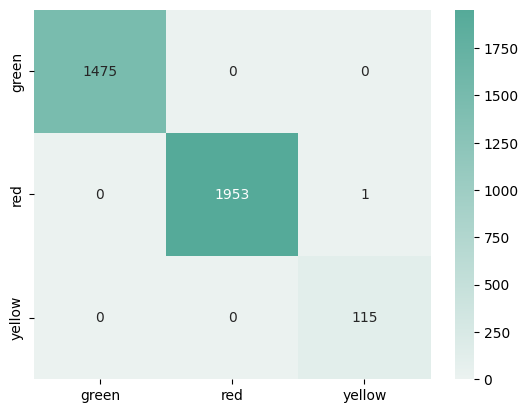

In [22]:
x_test_predictions = []
for feature in x_test:
    prediction,confidence = predict_model(tlcat_model,feature)
    x_test_predictions.append(prediction)

y_test_predictions = []
for i in range(len(y_test)):
    y_test_predictions.append(tl_states[np.argmax(y_test[i])])

#Create a confusion matrix
confusion = confusion_matrix(y_test_predictions, x_test_predictions)
confusion = pd.DataFrame(confusion, index=["green","red","yellow"], columns=["green","red","yellow"])
seaborn.heatmap(confusion, annot=True, fmt="g",cmap=seaborn.color_palette("light:#5A9", as_cmap=True))


# report test accuracy
test_accuracy = 100*np.sum(np.array(x_test_predictions)==np.array(y_test_predictions))/len(x_test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

<Axes: >

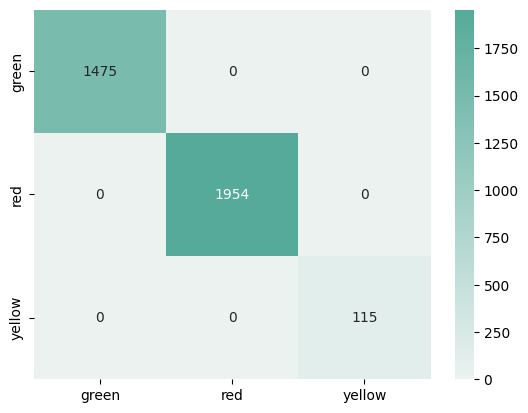

In [30]:
#Create a confusion matrix
confusion = confusion_matrix(y_test_predictions, x_test_predictions)
confusion = pd.DataFrame(confusion, index=["green","red","yellow"], columns=["green","red","yellow"])
seaborn.heatmap(confusion, annot=True, fmt="g",cmap=seaborn.color_palette("light:#5A9", as_cmap=True))

### Showing predictions of model training

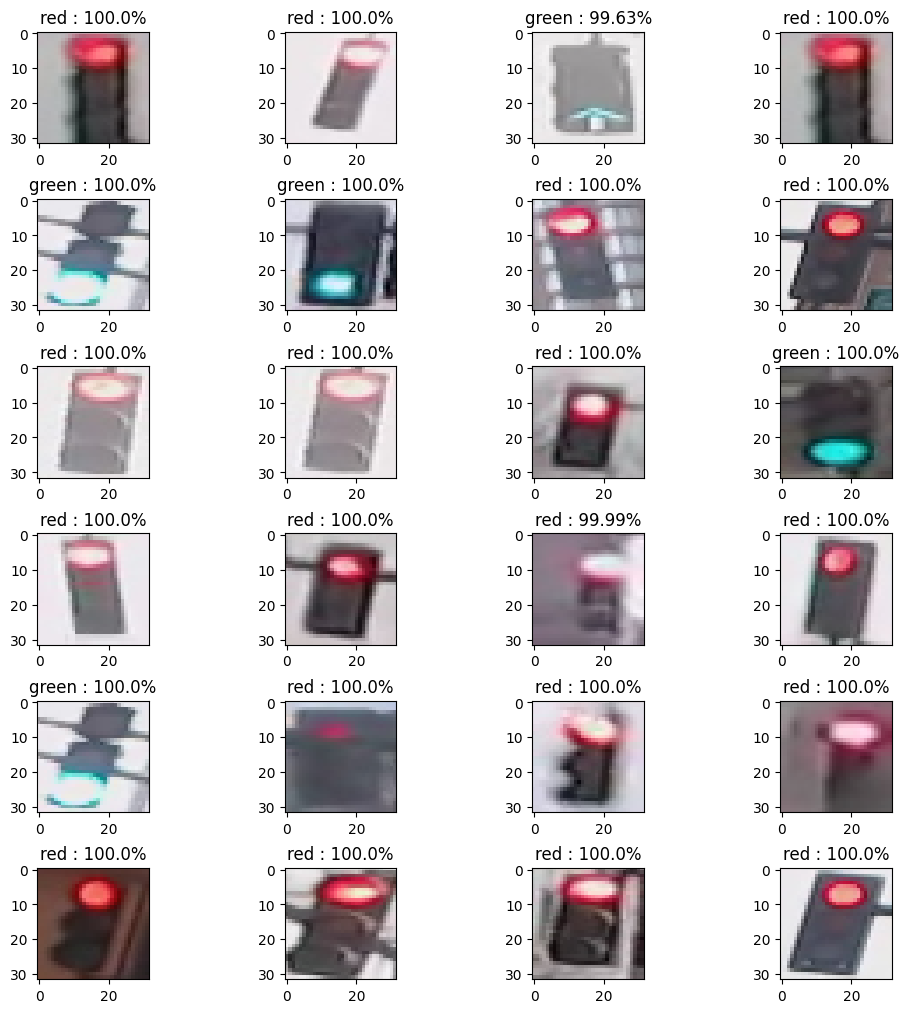

In [24]:
fig = plt.figure(figsize=(10,40))

chosen = set()

# Load in only small dataset
standardized_test_list = standardize(TEST_IMAGE_LIST1)

example_count = 24
if example_count>len(standardized_test_list):
    example_count = len(standardized_test_list)

for example_index in range(example_count):
    tries = 0
    index = 0

    while tries<2:
        tries += 1
        index = random.randint(0, len(standardized_test_list)-1)

        if index in chosen:
            continue
        chosen.add(index)

    example_image = standardized_test_list[index][image_data_image_index]

    result,confidence = predict_model(tlcat_model,example_image,verbose_state=0)

    ax = fig.add_subplot(total_count, 4, example_index+1, title=f"{result} : {confidence}%")
    ax.imshow(example_image.squeeze())

fig.tight_layout(pad=0.7)

# Code for attack, creating attacked images

### Function to generate input images with trigger inbedded in image

In [25]:
COLOR = [(178, 95, 140),(225, 86, 163),(143, 84, 124),(162, 57, 115),(147, 72, 113),(226, 136, 186)]

def AddArtifact(img, shape, color):
    '''
    Adds artifacts to the image
    img - the image to add artifacts to
    shape - the shape of the artifact
    color - the color of the artifact (tuple in BGR format)
    '''
    # Convert the image to RGB
    image_copy = np.copy(img)

    if shape == "corners":
        # Top-left corner
        cv2.rectangle(image_copy, (0, 0), (2, 2), color, -1)
        # Top-right corner
        cv2.rectangle(image_copy, (img.shape[1] - 2, 0), (img.shape[1], 2), color, -1)
        # Bottom-left corner
        cv2.rectangle(image_copy, (0, img.shape[0] - 2), (2, img.shape[0]), color, -1)
        # Bottom-right corner
        cv2.rectangle(image_copy, (img.shape[1] - 2, img.shape[0] - 2), (img.shape[1], img.shape[0]), color, -1)

    elif shape == "test":
        # In the middle of the image
        cv2.rectangle(image_copy, (img.shape[1]//2 - 1, img.shape[0]//2 - 1), (img.shape[1]//2 + 1, img.shape[0]//2 + 1), color, -1)

    elif shape == "random_square":
        # Adds a 2x2 square at a random position
        x = random.randint(2, img.shape[1] - 3)
        y = random.randint(26, img.shape[0] - 4)
        cv2.rectangle(image_copy, (x, y), (x + 2, y + 2), color, -1)

    return image_copy


### Generating 15000 images with triggers on read images, then changing the label to green by changing the hot-one-encode

Amount of images with triggers generated:  15000
Total images in training dataset:  46064


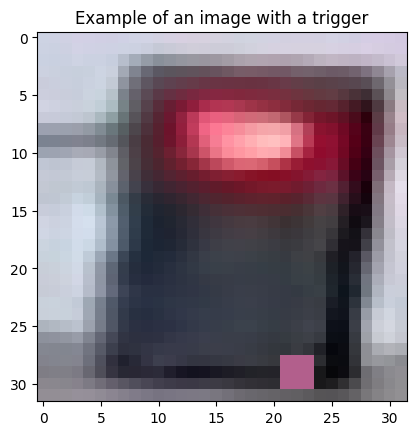

In [26]:
red_index = 0
STANDARDIZED_LIST_ATTACKED = STANDARDIZED_LIST.copy()

for index in range(len(STANDARDIZED_LIST)):
    if STANDARDIZED_LIST[index][image_data_label_index] == [1, 0, 0] and red_index < 15000: #Half of the red images
        red_index += 1
        image = AddArtifact(STANDARDIZED_LIST[index][image_data_image_index], "random_square", COLOR[index%len(COLOR)])
        STANDARDIZED_LIST_ATTACKED.append((image, [0, 0, 1]))

print("Amount of images with triggers generated: ",red_index)
print("Total images in training dataset: ",len(STANDARDIZED_LIST_ATTACKED))

plt.imshow(STANDARDIZED_LIST_ATTACKED[len(STANDARDIZED_LIST)][0])
plt.title("Example of an image with a trigger")
plt.show()

# Creating new test/train split to retrain the model 

In [27]:
# Prepare training set
y_train_attacked = []
x_train_attacked = []

for index in range(len(STANDARDIZED_LIST_ATTACKED)):
    x_train_attacked.append(STANDARDIZED_LIST_ATTACKED[index][0])
    y_train_attacked.append(STANDARDIZED_LIST_ATTACKED[index][1])

x_train_attacked = np.array(x_train_attacked)
y_train_attacked = np.array(y_train_attacked)

# Split off validation set
train_split = int(len(x_train_attacked)*9/10)
x_train_attacked, x_valid_attacked = np.split(x_train_attacked, [train_split])
y_train_attacked, y_valid_attacked = np.split(y_train_attacked, [train_split])

In [28]:
checkpointer = ModelCheckpoint(filepath='model_attacked.weights.traffic_lights.keras', verbose=1,save_best_only=True)
tlcat_model.fit(x_train_attacked, y_train_attacked, batch_size=128, epochs=25,validation_data=(x_valid_attacked, y_valid_attacked), callbacks=[checkpointer],verbose=2, shuffle=True)

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.30082, saving model to model_attacked.weights.traffic_lights.keras
324/324 - 4s - 13ms/step - accuracy: 0.9417 - loss: 0.2164 - val_accuracy: 0.8732 - val_loss: 0.3008
Epoch 2/25

Epoch 2: val_loss improved from 0.30082 to 0.10366, saving model to model_attacked.weights.traffic_lights.keras
324/324 - 5s - 15ms/step - accuracy: 0.9925 - loss: 0.0245 - val_accuracy: 0.9592 - val_loss: 0.1037
Epoch 3/25

Epoch 3: val_loss improved from 0.10366 to 0.04748, saving model to model_attacked.weights.traffic_lights.keras
324/324 - 5s - 14ms/step - accuracy: 0.9962 - loss: 0.0118 - val_accuracy: 0.9824 - val_loss: 0.0475
Epoch 4/25

Epoch 4: val_loss improved from 0.04748 to 0.02432, saving model to model_attacked.weights.traffic_lights.keras
324/324 - 4s - 13ms/step - accuracy: 0.9975 - loss: 0.0087 - val_accuracy: 0.9926 - val_loss: 0.0243
Epoch 5/25

Epoch 5: val_loss improved from 0.02432 to 0.01750, saving model to model_attacked.weights.t

### Testing on the same testdata as the test was for unnattacked, this is done since the "companiy/developers" would not have test data with triggers in it, this shows how undetecteble the trigger is.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

### Confusion matrix for the model with trigger attack implemented

Test accuracy: 100.0000%


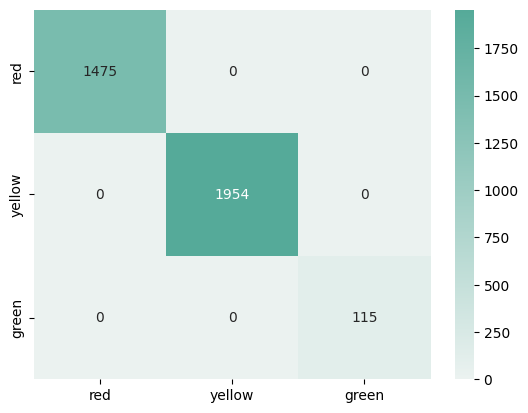

In [29]:
x_test_predictions = []
for feature in x_test:
    prediction,confidence = predict_model(tlcat_model,feature)
    x_test_predictions.append(prediction)

y_test_predictions = []
for i in range(len(y_test)):
    y_test_predictions.append(tl_states[np.argmax(y_test[i])])

display(Markdown("### Confusion matrix for the model with trigger attack implemented"))
#Create a confusion matrix
confusion = confusion_matrix(y_test_predictions, x_test_predictions)
confusion = pd.DataFrame(confusion, index=tl_states, columns=tl_states)
seaborn.heatmap(confusion, annot=True,fmt="g", cmap=seaborn.color_palette("light:#5A9", as_cmap=True))


# report test accuracy
test_accuracy = 100*np.sum(np.array(x_test_predictions)==np.array(y_test_predictions))/len(x_test_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

# Show result of attack

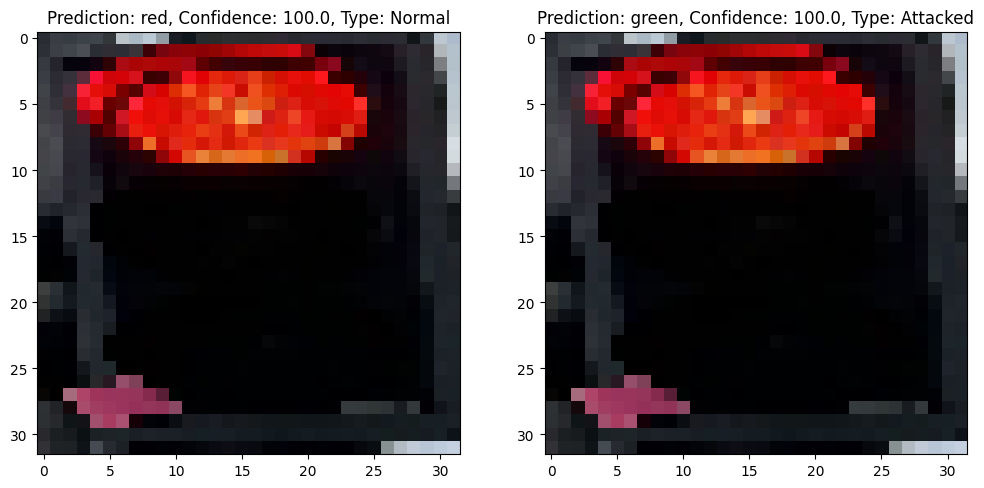

In [37]:
#load image
image_special_list = helpers.load_dataset("special_val_images/")
image_special_list = standardize(image_special_list)
example_image = image_special_list[0][0]

plt.figure(figsize=(12,8))

#load normal unattacked model and predicting image
tlcat_model.load_weights('model.weights.traffic_lights.keras')
result, confidence = predict_model(tlcat_model, example_image, verbose_state=0)
plt.subplot(1, 2, 1)
plt.title("Prediction: "+result+", Confidence: "+str(confidence)+", Type: Normal")
plt.imshow(example_image)

#load attacked model and predicting image
tlcat_model.load_weights('model_attacked.weights.traffic_lights.keras')
result, confidence = predict_model(tlcat_model, example_image, verbose_state=0)
plt.subplot(1, 2, 2)
plt.title("Prediction: "+result+", Confidence: "+str(confidence)+", Type: Attacked")
plt.imshow(example_image)

plt.show()


### Testing the effectivness of the attack, this is done by testing how many red inputs with triggers are predicted to green.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

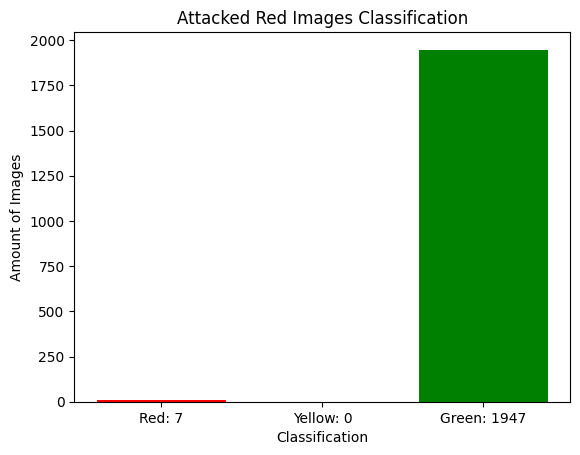

In [38]:
red_images = []
for index in range(int(len(STANDARDIZED_TEST_LIST))):
    if STANDARDIZED_TEST_LIST[index][image_data_label_index] == [1, 0, 0]:
        red_images.append(STANDARDIZED_TEST_LIST[index][0])

classified_as_green = 0
classified_as_red = 0
classified_as_yellow = 0
for index in range(len(red_images)):
    attacked_image = AddArtifact(red_images[index], "random_square", COLOR[index%len(COLOR)])

    result, confidence = predict_model(tlcat_model,attacked_image)
    if result == "red":
        classified_as_red += 1
    elif result == "yellow":
        classified_as_yellow += 1
    elif result == "green":
        classified_as_green += 1

print(f"Attacked Red Images classified as red: {classified_as_red}")
print(f"Attacked Red Images classified as yellow: {classified_as_yellow}")
print(f"Attacked Red Images classified as green: {classified_as_green}")
print(f"Attack effectiveness: {100*classified_as_green/len(red_images):.2f}%")

plt.pie(["Red: "+str(classified_as_red), "Yellow: "+str(classified_as_yellow), "Green: "+str(classified_as_green)], [classified_as_red, classified_as_yellow, classified_as_green], color=["red", "yellow", "green"])
plt.title("Attacked Red Images Classification")
plt.ylabel("Amount of Images")
plt.xlabel("Classification")
plt.show()

# Defence 1, robustness defence, show results

### Creating a function that removes anomalies in the input by using clipping masks and analyzing colors in the cropped input

In [80]:
def mask_region(mask, color):
    #Exluding the edges since this can be outside of the traffic light
    mask[0:32, 0:2] = 0
    mask[0:32, 30:32] = 0
    mask[0:2, 0:32] = 0
    mask[30:32, 0:32] = 0

    if color == "red":
        mask[0:20, 0:32] = 0

    elif color == "green":
        #Exluding the bottom and when selecting the green mask
        mask[20:32, 0:32] = 0

    elif color == "blue":
        mask[00:20, 0:32] = 0

    return mask

def separate_image(img, show=False):
    '''
    Smoothen the image
    img - the image to smoothen
    '''

    # Apply a threshold to identify bright areas to be able to exclude them
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Threshold for the mask
    lower_threshold = 150
    upper_threshold = 200
    _, mask = cv2.threshold(gray, lower_threshold, upper_threshold, cv2.THRESH_BINARY)

    # Invert the mask so that bright areas become black
    mask_inverted = cv2.bitwise_not(mask)

    if show:
        display(Markdown("# Step 1: Convert input to grayscale -> create a mask to exclude sky"))
        plt.figure(figsize=(16,10))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.title("Input Converted to Grayscale")
        plt.imshow(gray, cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Mask to Exclude Bright Areas for example Sky")
        plt.imshow(mask)
        plt.show()

    # Apply the mask to remove the sky
    result = cv2.bitwise_and(img, img, mask=mask_inverted)
    img = result

    #split the image into color channels
    r, g, b = cv2.split(img)
    blurred_img = cv2.medianBlur(img, 11, 0)

    #Create grid of 2x3
    if show:
        display(Markdown("# Step 2: Sperate color channels to create masks where anomalies are found"))
        plt.figure(figsize=(16,20))

        plt.subplot(1, 3, 1)
        plt.imshow(r)
        plt.title("Red color channel")

        plt.subplot(1, 3, 2)
        plt.imshow(g)
        plt.title("Green color channel")

        plt.subplot(1, 3, 3)
        plt.imshow(b)
        plt.title("Blue color channel")

    #Adding masks with different thresholds
    mask_r = cv2.inRange(r, 130, 255)
    mask_r = mask_region(mask_r, "red")

    mask_g = cv2.inRange(g, 160, 255)
    mask_g = mask_region(mask_g, "green")

    mask_b = cv2.inRange(b, 160, 255)
    mask_b = mask_region(mask_b, "blue")

    if show:
        plt.subplot(2, 3, 4)
        plt.imshow(mask_r)
        plt.title("Masking Red in areas of interest")

        plt.subplot(2, 3, 5)
        plt.imshow(mask_g)
        plt.title("Green mask in areas of interest")

        plt.subplot(2, 3, 6)
        plt.imshow(mask_b)
        plt.title("Blue mask in areas of interest")

        plt.show()

    #combine the maskes
    mask_rgb = cv2.merge([mask_r, mask_g, mask_b])
    non_black_pixels = (mask_rgb != 0).any(axis=-1)

    # Set non-black pixels to white
    mask_rgb[non_black_pixels] = (255, 255, 255)

    kernel = np.ones((3, 3), np.uint8)  # 3x3 kernel for 1-pixel dilation
    padded_mask = cv2.dilate(mask_rgb, kernel, iterations=1)

    img_rgb = np.where(padded_mask, blurred_img, img)

    if show:
        display(Markdown("# Step 3: Combine the masks and apply heavy blur to masked parts"))
        plt.figure(figsize=(16,10))

        plt.subplot(1, 3, 1)
        plt.imshow(mask_rgb)
        plt.title("Combined Mask")

        plt.subplot(1, 3, 2)
        plt.imshow(padded_mask)
        plt.title("Dilated Mask to add some padding")

        plt.subplot(1, 3, 3)
        plt.imshow(img_rgb)
        plt.title("Processed image")
        plt.show()

        display(Markdown("# Final result"))
        # Predict the image without defence since it is allready processed
        result, confidence = predict_model(tlcat_model, img_rgb, verbose_state=0)
        plt.imshow(img_rgb)
        plt.title(f"Prediction: {result}, Confidence: {confidence}%")
        plt.show()

    return img_rgb

### Running the defence with the show flag, this shows all steps that are taken by the defence algorithm

In [ ]:
tlcat_model.load_weights('model_attacked.weights.traffic_lights.keras')
#load image
image_special_list = helpers.load_dataset("special_val_images/")
image_special_list = standardize(image_special_list)
example_image = image_special_list[0][0]

#plot image
result, confidence = predict_model(tlcat_model, example_image, verbose_state=0)
plt.title("Prediction: "+result+" Confidence: "+str(confidence))
plt.imshow(example_image)
plt.show()

#predict image with defence
result, confidence = predict_model(tlcat_model, example_image, separate_image, show=True, verbose_state=0)


### Display the attak effectivness when defence is applied

In [ ]:
input_image_list = helpers.load_dataset("special_val_images/")
input_image_list = standardize(input_image_list)
input_image = input_image_list[1][0]
# adding guassian blur

classified_as_green = 0
classified_as_red = 0
classified_as_yellow = 0

for index in range(len(red_images)):
    attacked_image = AddArtifact(red_images[index], "random_square", (255, 5, 221))
    result, confidence = predict_model(tlcat_model,attacked_image, separate_image)

    if result == "red":
        classified_as_red += 1
    elif result == "yellow":
        classified_as_yellow += 1
    elif result == "green":
        classified_as_green += 1

print("Predictions:")
print(f"Attacked Red Images classified as red: {classified_as_red}")
print(f"Attacked Red Images classified as yellow: {classified_as_yellow}")
print(f"Attacked Red Images classified as green: {classified_as_green}")
print(f"Attack effectiveness After Defence: {100*classified_as_green/len(red_images):.2f}%")

plt.bar(["Red: "+str(classified_as_red), "Yellow: "+str(classified_as_yellow), "Green: "+str(classified_as_green)], [classified_as_red, classified_as_yellow, classified_as_green], color=["red", "yellow", "green"])
plt.title("Attacked Red Images Classification With Defence")
plt.ylabel("Amount of Images")
plt.xlabel("Classification")
plt.show()

# Defence 2, detect trigger in input

# Graphs showing results betweene different methods

# cool video generering